# **Chapter 21**  
**┗ 물류 유통량 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「유통량 EDA」
* 🥈Session 2 - 「지역별 유통량 탐색」
* 🥇Session 3 - 「ML 활용 유통량 예측」

In [1]:
# 한글 폰트 설치 후 런타임 재시작 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# import matplotlib.pyplot as plt
# plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (23.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and di

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter21')
# '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter21' ← 변경X
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter21'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🚛 (물류 관리자)

```
A물류업체는 상/하차 과정에서 물품 파손 등에 대한 고객 클레임 건수가 증가하고 있다. 물품의 특성마다 조심해야하는 부분이 다르기 때문에  
여간 힘든 일이 아니다. 따라서 A사는 특정 물품이 많이 배송되는 지역들을 구분하고 용도에 맞는 적절한 택배차량을 선정하여 배송을 운영하려고 한다.
```  

> **데이터 살펴보기**

* 출발지 정보인 '송하인_격자공간고유번호', 도착지 정보인 '수하인_격자공간고유번호'가 있고, 물품카테고리별 건수가 적재되어 있다.


In [2]:
# ▶ Data read
import pandas as pd 
df = pd.read_csv('chatper21_logistic.csv', encoding='cp949')
df.head(10)

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
5,5,5013000778073200,4159000114016400,농산물,6
6,6,5011000316024300,4827000369060200,수산,5
7,7,5013000740006400,4111700017039400,농산물,3
8,8,4136000209094100,5013000823053400,아우터,3
9,9,5011000315056100,4127100026035200,농산물,8



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 상품 배송 고객 Claim건수 증가, 물품 파손 건수 증가
```  

> **기대효과**

```
▶ 고객 Claim건수 감소, 물품 파손 건수 감소 
```

> **해결방안**

```
▶ 지역별 물품 배송량 분석을 통해 적정 차량 배차 및 직원 교육 
▶ Session 1 🥉
 - Data 전처리 및 배송지역 및 물품 카테고리 현황 데이터 탐색
▶ Session 2 🥈
 - 출발지와 도착지에 배송건수/물품 카테고리에 대해 분석 및 유통경로 분석 
▶ Session 3 🥇
 - ML 알고리즘을 활용하여 배송량 예측
```

> **성과측정**  

```
▶ 배송 운영 후 Claim건수 모니터링 
```

> **현업적용**  

```
▶ 지역별 물품 배송 특성 추출 및 배차
▶ 직원 교육을 통한 고객 Claim 감소 활동
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → set(), value_counts()
▶ session 2 → list.append()
▶ session 3 → RandomForestRegressor(), LabelEncoder(), mean_absolute_error, r2_score
```

## **🥉Session 1**  
**┗ 유통량 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [3]:
# ▶ Data 형태 확인
# ▶ 31,684 row, 5 col로 구성됨
print('df', df.shape)

df (31684, 5)


In [4]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         31684 non-null  int64 
 1   송하인_격자공간고유번호  31684 non-null  int64 
 2   수하인_격자공간고유번호  31684 non-null  int64 
 3   물품_카테고리       31684 non-null  object
 4   운송장_건수        31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


In [5]:
# ▶ Null 값 확인
print(df.isnull().sum())

index           0
송하인_격자공간고유번호    0
수하인_격자공간고유번호    0
물품_카테고리         0
운송장_건수          0
dtype: int64


In [6]:
# ▶ Outlier 확인
df.describe()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,운송장_건수
count,31684.000000,3.168400e+04,3.168400e+04,31684.000000
mean,15841.500000,4.648814e+15,3.801369e+15,4.879308
std,9146.527301,8.341336e+14,1.314660e+15,6.756473
min,0.000000,1.111000e+15,1.111000e+15,3.000000
25%,7920.750000,4.713000e+15,2.826000e+15,3.000000
50%,15841.500000,5.011000e+15,4.159000e+15,3.000000
75%,23762.250000,5.013001e+15,5.011000e+15,5.000000
max,31683.000000,5.013001e+15,5.013001e+15,413.000000


### · 배송 지역 탐색
---


In [7]:
df.head(5)

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [8]:
# ▶ Col rename
df.columns = ['index', 'start', 'end', 'prod', 'cnt']
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [9]:
# ▶ 배송 출발지 4,229개소
df['start'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4511300030055300       1
4719000321023400       1
4423000423020300       1
4711300748080100       1
2811000139076100       1
Name: start, Length: 4229, dtype: int64

In [10]:
# ▶ 배송 도착지 26,875개소, 출발지보다 배송지의 지역이 더 많음
df['end'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000544072300    30
5011000318044100    30
                    ..
5011000109040100     1
4183000550093100     1
4425000028078200     1
1147000011064300     1
5011000263065200     1
Name: end, Length: 26875, dtype: int64

In [11]:
# ▶ 총 지역(출발+배송) 30,455개
all_list = list(df['start']) + list(df['end'])
unique_list = set(all_list)
len(unique_list)

30455

### · 물품 카테고리 탐색
---


In [12]:
# ▶ 물품의 종류 탐색(총 100개의 물품 카테고리)
df['prod'].value_counts().head(30)

농산물          20321
문화컨텐츠         1091
음료            1034
수산             860
가공식품           846
기타식품           698
건강식품           591
음반             576
축산             383
냉동/간편조리식품      375
과자             320
생활용품           318
반려동물           315
주방용품           300
상의             294
기타패션의류         236
기타디지털/가전       220
스킨케어           205
문구/사무용품        167
건강용품           162
아우터            155
하의             150
기저귀/물티슈        130
기타화장품/미용       102
공구              95
다이어트식품          92
의료용품            82
인테리어소품          72
신발              70
취미용품            66
Name: prod, dtype: int64

In [13]:
# ▶ 운송장 건수 기준, 내림차순 정렬
df_cnt = df.groupby('prod', as_index=False)['cnt'].sum()
df_cnt = df_cnt.sort_values(by=['cnt'], ascending = False )
df_cnt.head(30)

,prod,cnt
27,농산물,87829
66,음료,5890
3,가공식품,5766
34,문화컨텐츠,5429
51,수산,4880
17,기타식품,4250
5,건강식품,3413
80,축산,3385
19,기타패션의류,3042
67,음반,2357


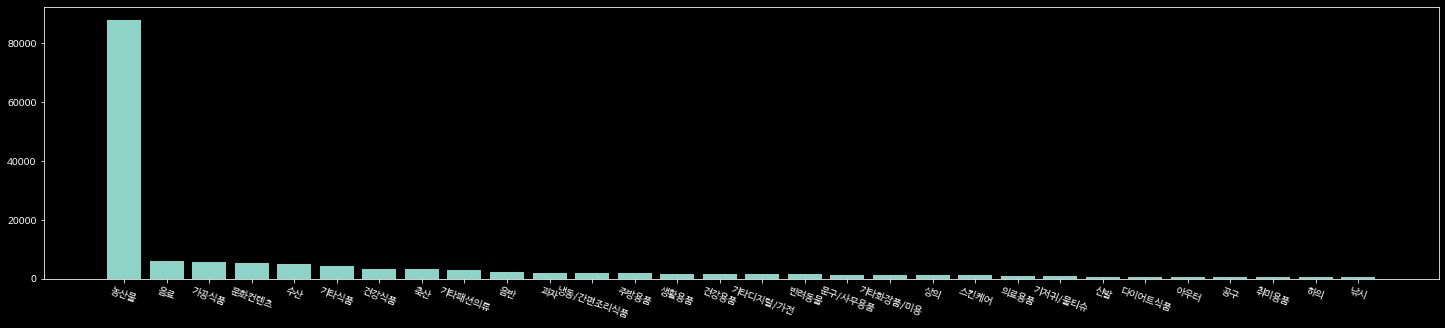

In [14]:
# ▶ 운송장 건수 기준, 내림차순 정렬 Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.rc('font', family='NanumBarunGothic') 
plt.bar(df_cnt['prod'][0:30], df_cnt['cnt'][0:30], label='cnt');
plt.xticks(rotation =-20);
plt.gcf().set_size_inches(25, 5);

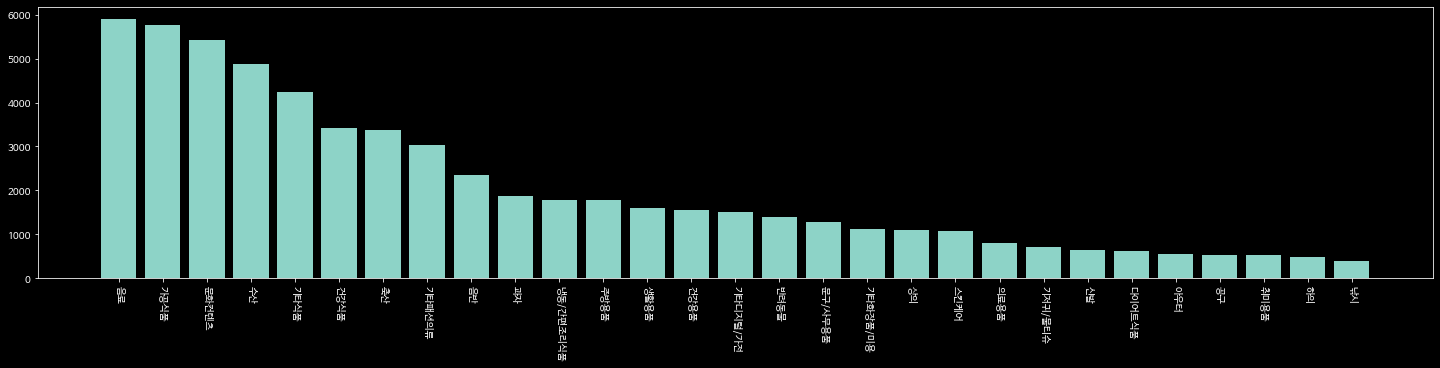

In [15]:
# ▶ 운송장 건수 기준, 내림차순 정렬 Plotting (※ 농산물 제거)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.rc('font', family='NanumBarunGothic') 

# ▶ 막대그래프 위치 변경을 원하면 plt.barh 함수 사용
plt.bar(df_cnt['prod'][1:30], df_cnt['cnt'][1:30], label='cnt');
plt.xticks(rotation =-90);
plt.gcf().set_size_inches(25, 5);

## **🥈Session 2**  
**┗ 지역별 유통량 탐색**  
---

In [16]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


### · 출발지/도착지 분석
---


In [17]:
# ▶ 가장 많이 배송이 출발되는 지역
df['start'].value_counts()

5011000078068400    3882
5013000610049100    1790
5013000731055200    1235
5011000137030100    1137
5013000821028200     731
                    ... 
4511300030055300       1
4719000321023400       1
4423000423020300       1
4711300748080100       1
2811000139076100       1
Name: start, Length: 4229, dtype: int64

In [18]:
# ▶ 출발지 기준 상위 500개의 장소에서 전체 배송건수에 80%이상을 조달함
df['start'].value_counts().head(500).sum() / df['start'].value_counts().sum()

0.7936182300214619

In [19]:
# ▶ 가장 많이 배송이 도착되는 지역
df['end'].value_counts()

5013000635005300    35
5011000543041100    33
5011000314069300    33
5011000544072300    30
5011000318044100    30
                    ..
5011000109040100     1
4183000550093100     1
4425000028078200     1
1147000011064300     1
5011000263065200     1
Name: end, Length: 26875, dtype: int64

In [20]:
# ▶ 도착지 기준 상위 약 20,000개의 장소에서 전체 배송건수에 80%이상을 조달함
df['end'].value_counts().head(20500).sum() / df['end'].value_counts().sum()

0.7987943441484661

In [21]:
df_start_end = pd.DataFrame({'start' : df['start'].value_counts(), 'end': df['end'].value_counts()})
df_start_end.fillna(0, inplace = True)
df_start_end['total'] = df_start_end['start'] + df_start_end['end']
df_start_end.head(5)

,start,end,total
1111000004097200,0.0,1.0,1.0
1111000005062300,0.0,1.0,1.0
1111000005067400,0.0,1.0,1.0
1111000007059100,0.0,1.0,1.0
1111000007071100,0.0,1.0,1.0


In [22]:
# ▶ 출발 및 배송 건수가 가장 많은 지역
df_start_end.sort_values(by=['total'], ascending = False).head(10)

,start,end,total
5011000078068400,3882.0,14.0,3896.0
5013000610049100,1790.0,0.0,1790.0
5013000731055200,1235.0,0.0,1235.0
5011000137030100,1137.0,2.0,1139.0
5013000821028200,731.0,0.0,731.0
4148000690015300,582.0,0.0,582.0
5013000777063100,475.0,0.0,475.0
5011000595017300,462.0,1.0,463.0
5011000213090100,454.0,3.0,457.0
5011000685067100,453.0,0.0,453.0


### · 유통경로 분석
---

In [23]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [24]:
# ▶ 생각보다 자주 배송되는 특정 경로 배송이 없다.
# ▶ 이렇게 되면 경로 기준으로 배차를 하는 방법은 사용불가능
df_route = df.groupby(['start', 'end'], as_index=False)['prod'].count()
df_route.colimns = ['start', 'end', 'cnt']
df_route = df_route.sort_values(by=['prod'], ascending = False)
df_route.head(10)

,start,end,prod
3684,4141000031030100,5013000635005300,7
6712,4211000650079200,5011000437052400,7
735,1154500001021400,5011000214025100,5
3664,4141000031030100,5011000596012200,5
6962,4374500066090200,5011000427079100,5
2814,4128500028049400,5011000373021200,4
14369,5011000228004400,4117300017043200,4
3536,4141000031030100,5011000318044100,4
6952,4374000244008400,5011000373055300,4
3269,4137000019060200,5011000366024400,4


In [25]:
# ▶ 가장 많이 배송되는 지역 > 물품이 다양하기 때문에 카테고리화도 쉽지 않겠다.
df[(df['start']==4141000031030100) & (df['end']==5013000635005300)]

,index,start,end,prod,cnt
4810,4810,4141000031030100,5013000635005300,주방용품,7
5657,5657,4141000031030100,5013000635005300,이미용가전,4
14325,14325,4141000031030100,5013000635005300,스킨케어,7
17413,17413,4141000031030100,5013000635005300,생활가전,3
19976,19976,4141000031030100,5013000635005300,음료,3
20177,20177,4141000031030100,5013000635005300,베이스메이크업,5
22653,22653,4141000031030100,5013000635005300,상의,3


### · 출발지 기준 배차분석
---
* 출발기준으로 가장 많이 배송하는 물품을 대표 물품으로 선정

In [26]:
 # ▶ 출발 지역에서 가장 많이 배송되는 물품을 대표 물품으로 정의
 pd.DataFrame(df[df['start']==4141000031030100].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)

,prod,cnt
0,건강용품,468


In [27]:
# ▶ 모든 출발 배송 지역에 대해서 상위 조건을 수행하기위한 for문 작성 
list_of_df = [] 

for i in list(df['start'].unique()) :
  loop_df = pd.DataFrame(df[df['start']==i].groupby('prod')['cnt'].sum().sort_values(ascending=False)).reset_index().head(1)
  loop_df['id'] = i
  list_of_df.append(loop_df)

df_accum_start = pd.concat(list_of_df) 

In [28]:
df_accum_start

,prod,cnt,id
0,음반,1652,5011000595017300
0,문화컨텐츠,383,4148000690043300
0,농산물,14380,5011000078068400
0,기타식품,96,4127100048006400
0,농산물,492,5013000778073200
...,...,...,...
0,기타패션잡화,9,4113300019005400
0,침구세트,4,4873000294001400
0,기타패션잡화,105,2638000008087200
0,스마트디바이스액세서리,3,1120000013030100


In [29]:
# ▶ 물품별 전체 배송량 데이터 생성 
df_prod_sum = pd.DataFrame(df.groupby('prod', as_index = False)['cnt'].sum())
df_prod_sum.columns = ['prod', 'total']
df_prod_sum.head(5)

,prod,total
0,DIY자재/용품,150
1,PC,200
2,PC주변기기,30
3,가공식품,5766
4,가방,26


In [30]:
# ▶ 출발지 기준 물품 배송량에 left join
df_merge = pd.merge(df_accum_start, df_prod_sum, how='left', on='prod')
df_merge = df_merge[['id', 'prod', 'cnt', 'total']]
df_merge.head(5)

,id,prod,cnt,total
0,5011000595017300,음반,1652,2357
1,4148000690043300,문화컨텐츠,383,5429
2,5011000078068400,농산물,14380,87829
3,4127100048006400,기타식품,96,4250
4,5013000778073200,농산물,492,87829


In [31]:
# ▶ 전체 물품 배송량중 몇 퍼센트를 싣고 떠나는지 분석을 통해 차량 배차가 가능해짐
df_merge['ratio'] = df_merge['cnt'] / df_merge['total']
df_merge.head(5)

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
1,4148000690043300,문화컨텐츠,383,5429,0.070547
2,5011000078068400,농산물,14380,87829,0.163727
3,4127100048006400,기타식품,96,4250,0.022588
4,5013000778073200,농산물,492,87829,0.005602


In [32]:
# ▶ 전체 물품중 적어도 50% 이상을 출발시키는 곳에 특성 배차를 할 수 있을 것임
# ▶ 배차완료!
df_merge[df_merge['ratio'] > 0.50]

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
57,4148000427007400,출산/유아동의류,23,30,0.766667
70,4148000690015300,문화컨텐츠,3064,5429,0.564376
96,1117000009037100,기타디지털/가전,837,1505,0.556146
359,4127300022051100,위생/건강용품,135,249,0.542169
457,5011000320025200,네일케어,35,69,0.507246
584,4873000228047300,낚시,316,386,0.818653
596,4150000196034300,다이어트식품,419,619,0.676898
1109,4117300018005400,기타패션의류,1605,3042,0.527613
1129,4413300143027400,신발,392,637,0.615385


## **🥇Session 3**  
**┗ ML 활용 유통량 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [33]:
df.head(5)

,index,start,end,prod,cnt
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3


In [34]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

X=df.drop(['index', 'cnt'], axis=1)
Y=df['cnt']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1239)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(19010, 3)
(19010,)
(12674, 3)
(12674,)


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(x_train['prod'].values) + list(x_test['prod'].values))
x_train['prod'] = le.transform(x_train['prod'])
x_test['prod'] = le.transform(x_test['prod'])

In [37]:
x_test['prod'].head(5)

17822    27
2269     51
37       27
24369    27
17187    27
Name: prod, dtype: int64

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [50]:
rfr = RandomForestRegressor(n_estimators=300, max_depth=8)
# rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=300)

In [51]:
# ▶ 예측
# ▶ 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)


mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_score(r2): ', r2_train)
print('')
mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_score(r2): ', r2_test)

mae_train(mae):  2.2012630977633565
r2_score(r2):  0.29908898666230654

mae_test(mae):  2.302878721232062
r2_score(r2):  0.22550985585104033


In [52]:
pd.options.display.float_format = '{:.5f}'.format
result = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred_test})
result['diff'] = result['Real Values'] - result['Predicted Values']
result.head(10)

,Real Values,Predicted Values,diff
17822,3,3.96881,-0.96881
2269,10,5.48345,4.51655
37,3,3.65003,-0.65003
24369,12,4.20638,7.79362
17187,3,4.27212,-1.27212
23981,3,5.03714,-2.03714
24832,10,3.87700,6.12300
11358,3,5.43775,-2.43775
12473,4,9.42396,-5.42396
19441,3,4.49125,-1.49125


In [60]:
result[result['diff']>20]

,Real Values,Predicted Values,diff
23314,109,7.66325,101.33675
22050,68,5.54243,62.45757
9417,30,9.19754,20.80246
8971,32,5.89581,26.10419
30697,29,5.26424,23.73576
...,...,...,...
8658,32,4.24922,27.75078
8366,27,5.08780,21.91220
11596,33,6.28625,26.71375
24382,44,6.46600,37.53400


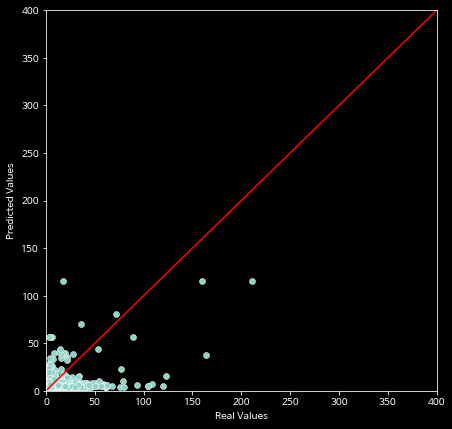

In [62]:
# ▶ 성능이 좋지 않을땐? 해당 지역에 평균 배송량을 사용하는 것이 훨씬 이득인 경우가 많음 
sns.scatterplot(result['Real Values'], result['Predicted Values'])
plt.xlim(0, 400)
plt.ylim(0, 400)

x = [0, 400]
y = [0, 400]
plt.plot(x, y, color='red')
plt.gcf().set_size_inches(7 ,7)

### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

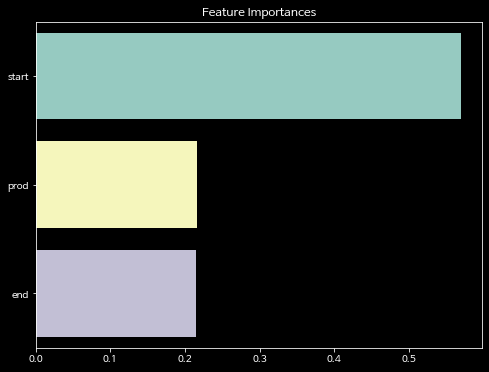

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfr.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfr)

# 모델 Read
rfr_from_pickle = pickle.loads(saved_model)

In [ ]:
# ▶ Summary
# (1) 출발지 : 4,229개소 / 도착지 : 26,875개소
# (2) 총 배송량(80%) : 출발지(상위 500개소), 도착지(상위 20,500개소)
# (3) 대표 물품 선정 
#    - 가장 많이 배송하는 물품
#    - 전체 물품 배송물량 중 최소 50%이상을 배송하는 지역

# 배차를 위한 최종 데이터(feat. 취급주의 품목)
df_merge[df_merge['ratio'] > 0.50].loc[(0, 70, 96, 457, 1179, 1813, 1927),:]

,id,prod,cnt,total,ratio
0,5011000595017300,음반,1652,2357,0.700891
70,4148000690015300,문화컨텐츠,3064,5429,0.564376
96,1117000009037100,기타디지털/가전,837,1505,0.556146
457,5011000320025200,네일케어,35,69,0.507246
1179,3020000121041200,선글라스/안경테,14,27,0.518519
1813,4374500066090200,태블릿PC/노트북액세서리,25,40,0.625000
1927,4139000127044300,게임기/타이틀,60,87,0.689655
